## How could Olist improve its profit 
## Investigate following problems:
>❓ How many underperforming sellers should Olist remove to improve its profit, given that it has:
> - some revenues per sellers per months
> - some revenues per orders
> - some reputation costs (estimated) per bad reviews
> - some operational costs of IT system that grows with number of order items, but not linearly (scale effects)

## 1. Summary of Problem Statement

### P&L Rules

#### Revenues  
**Sales fees:** Olist takes a **10% cut** on the product price (excl. freight) of each order delivered  
**Subscription fees:** Olist charges **80 BRL by month** per seller

#### Costs
_Estimated_ **reputation costs** of orders with bad reviews (<= 3 stars)  

💡 In the long term, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication. I make an assumption about the monetary cost for each bad review:

```python
# review_score: cost(BRL)
{'1 star': 100
'2 stars': 50
'3 stars': 40
'4 stars': 0
'5 stars': 0}
```

**IT costs:** Olist's **total cumulated IT Costs** scale with the square root of the total number of sellers that have ever joined the platform, as well as with the square root of the total cumulated number of items that were ever sold.  

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_items}$  

Olist's data team gave us the following values for these scaling parameters:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Both the number of sellers to manage and the number of sales transaction are costly for IT systems.  
💡 Yet square roots reflect scale-effects: IT-system are often more efficient as they grow bigger.  
💡 Alpha > Beta means that Olist has a lower IT Cost with few sellers selling a lot of items rather than the opposite  
- with **1000 sellers** and a total of **100 items** sold, the total IT cost accumulates to 109,624 BRL
- with **100 sellers** and a total of **1000 items** sold, the total IT cost accumulates to 62,507 BRL

Finally, The IT department also told you that since the birth of the marketplace, cumulated IT costs have amounted to **500,000 BRL**.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


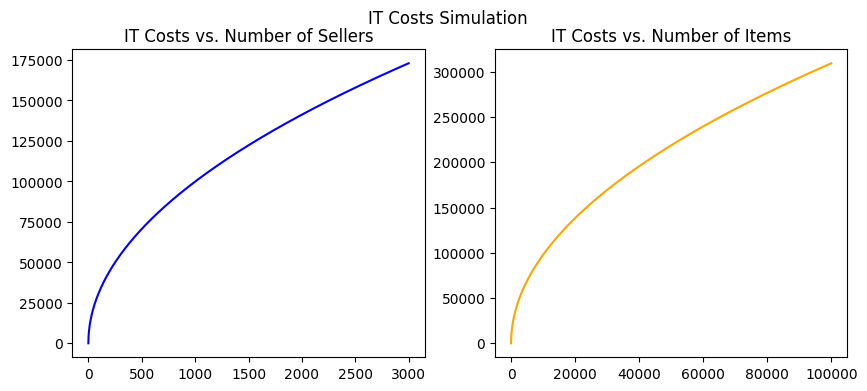

In [68]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

alpha = 3157.27
beta = 978.23

x_sellers = np.arange(3_000)
y_it_costs_sellers = alpha * x_sellers ** 0.5

x_items = np.arange(100_000)
y_it_costs_items = beta * x_items ** 0.5

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(x_sellers, y_it_costs_sellers, label='IT costs per seller', color='blue')
plt.title('IT Costs vs. Number of Sellers')
plt.subplot(1, 2, 2)
plt.plot(x_items, y_it_costs_items, label='IT costs per item', color='orange')
plt.title('IT Costs vs. Number of Items')
plt.suptitle('IT Costs Simulation');

### Key Findings, so far

- `wait_time` is the most significant factor behind low review scores.  
- `wait_time` is made up of seller's `delay_to_carrier` + `carrier_delivery_time`. 
- Because the carrier's delivery time is out of Olist's direct control, improving it is not a quick-win recommendation.
- On the contrary, a better selection of `sellers` can positively impact the `delay_to_carrier` and reduce the number of bad `review_scores` on Olist.
- Comments in the bad reviews showed that some were linked to the seller or to the product itself.

## 2. Should Olist remove under-performing sellers from its marketplace? 

**What would have happened if Olist had never accepted these sellers in the first place?**  



### 2.1 Data Preparation

Compute, for each `seller_id`, and cumulated since the beginning:
- the `revenues` the seller brings
- the `review_costs` associated with the seller's bad reviews
- the resulting `profits` (revenues - costs)

 2.2  Analysis without IT costs



Here are my steps:  

1️⃣ Load the sellers data and sort them by decreasing profits.

2️⃣ Calculate cumulative amounts:
   - Calculate the cumulative revenues for each row.
   - Calculate the cumulative profits for each row.
   - Calculate the cumulative quantity of items sold for each row.
3️⃣ Plot your results, and analyze them. Use Pandas' `.plot()` method.

4️⃣ Determine the optimum number of sellers to keep, based on profits. What would have been the impact on:
   - Net profit ?
   - Total revenues?
   - Number of sellers?
   - Number of items sold?

In [ ]:
from olistClass.seller import Seller
seller = Seller()

In [4]:
sellers = seller.get_training_data()

/Users/gechen/Projects/OlistDataAnalysis/olistClass/seller.py:102: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  df = orders_sellers.groupby('seller_id').agg({
/Users/gechen/Projects/OlistDataAnalysis/olistClass/seller.py:102: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df = orders_sellers.groupby('seller_id').agg({


In [7]:
metrics_ordered = sellers[['revenues', 'cost_of_reviews', 'profits', 'quantity']] \
                  .sort_values(by='profits', ascending=False) \
                  .reset_index().drop(columns='index')
metrics_ordered.cost_of_reviews *= -1
metrics_ordered['n_sellers'] = 1
metrics_ordered

,revenues,cost_of_reviews,profits,quantity,n_sellers
0,23237.605,-5170,18067.605,410,1
1,19323.187,-4700,14623.187,340,1
2,21004.203,-6510,14494.203,586,1
3,8808.455,-1520,7288.455,175,1
4,14651.119,-7500,7151.119,542,1
...,...,...,...,...,...
2962,2553.569,-15440,-12886.431,1018,1
2963,4677.752,-20220,-15542.248,1203,1
2964,11948.842,-29530,-17581.158,1775,1
2965,21647.292,-39400,-17752.708,1987,1


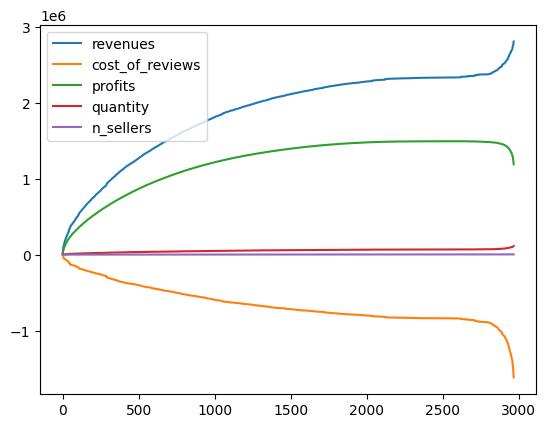

In [ ]:
# Compute the cumulative sum of the ordered metrics and plot them to visualize
# how the values accumulate across the index (e.g., showing cumulative growth or distribution).
metrics_cumulative = metrics_ordered.cumsum()
metrics_cumulative.plot();

In [12]:
#Find the optimal profit 
optimum_without_it = metrics_cumulative.profits.argmax()
optimum_without_it

2595

,impact
revenues,-473776.488
cost_of_reviews,778040.000
profits,304263.512
quantity,-44938.000
n_sellers,-371.000


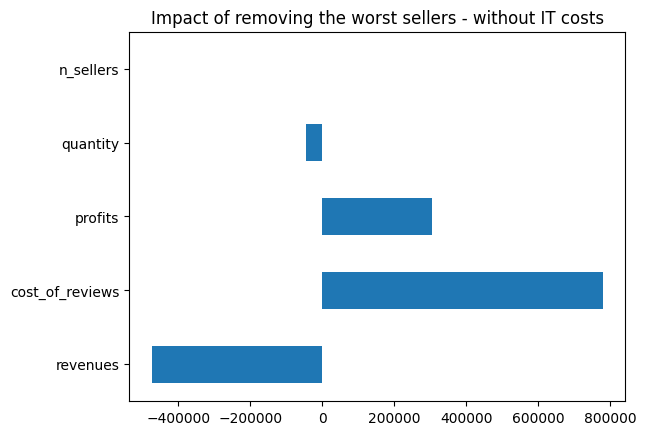

In [15]:
# Calculating the impact of removing the worst sellers
impact_without_it_costs = metrics_cumulative.iloc[optimum_without_it] - metrics_ordered.sum()
display(pd.DataFrame(impact_without_it_costs, columns=["impact"]))
impact_without_it_costs.plot(kind='barh', title="Impact of removing the worst sellers - without IT costs");

### Analysis with IT costs

Here are my steps:  

1️⃣ Write a function that will calculate IT costs based on two parameters: number of sellers and number of items. Basically write out the mathematical formula using python.

2️⃣ Load the sellers data and sort them by decreasing profits (before IT costs).

3️⃣ Calculate cumulative amounts (reuse the code from before):
   - Calculate the cumulative revenues for each row.
   - Calculate the cumulative profits for each row.
   - Calculate the cumulative quantity of items sold for each row.  

4️⃣ Calculate the impact of IT costs:
   - Using the function you wrote in step 1️⃣, add the cumulative cost of IT for each row.
   - Calculate net profit after IT costs.

5️⃣ Plot your results, and analyze them.

6️⃣ Determine the optimum number of sellers to keep, based on profits after IT costs this time. What would have been the impact on:
   - Net profit after IT costs?
   - Net profit before IT costs
   - IT costs?
   - Total revenues?
   - Number of sellers?
   - Number of items sold?

How important were the IT costs in your analysis?

In [ ]:
def cost_of_it(sellers, alpha, beta):
    """
    Function to calculate the IT costs
    """
    it_costs = alpha * sellers['n_sellers'] ** 0.5 + beta * sellers['quantity'] ** 0.5
    return it_costs

In [ ]:
# Calcualte the cumulative sum of metrics to get the sum of data
metrics_cumulative_with_it = metrics_ordered.cumsum()
metrics_cumulative_with_it

,revenues,cost_of_reviews,profits,quantity,n_sellers
0,23237.605,-5170,18067.605,410,1
1,42560.792,-9870,32690.792,750,2
2,63564.995,-16380,47184.995,1336,3
3,72373.450,-17900,54473.450,1511,4
4,87024.569,-25400,61624.569,2053,5
...,...,...,...,...,...
2962,2755294.075,-1493770,1261524.075,105443,2963
2963,2759971.827,-1513990,1245981.827,106646,2964
2964,2771920.669,-1543520,1228400.669,108421,2965
2965,2793567.961,-1582920,1210647.961,110408,2966


In [72]:
metrics_cumulative_with_it['it_costs'] = - cost_of_it(metrics_cumulative_with_it, alpha, beta)
metrics_cumulative_with_it

,revenues,cost_of_reviews,profits,quantity,n_sellers,it_costs
0,23237.605,-5170,18067.605,410,1,-22964.917828
1,42560.792,-9870,32690.792,750,2,-31254.985925
2,63564.995,-16380,47184.995,1336,3,-41224.163282
3,72373.450,-17900,54473.450,1511,4,-44339.889079
4,87024.569,-25400,61624.569,2053,5,-51383.513743
...,...,...,...,...,...,...
2962,2755294.075,-1493770,1261524.075,105443,2963,-489511.812301
2963,2759971.827,-1513990,1245981.827,106646,2964,-491347.711731
2964,2771920.669,-1543520,1228400.669,108421,2965,-494024.237152
2965,2793567.961,-1582920,1210647.961,110408,2966,-496991.389117


,revenues,cost_of_reviews,profits,quantity,n_sellers,it_costs,profits_after_it
0,23237.605,-5170,18067.605,410,1,-22964.917828,-4897.312828
1,42560.792,-9870,32690.792,750,2,-31254.985925,1435.806075
2,63564.995,-16380,47184.995,1336,3,-41224.163282,5960.831718
3,72373.450,-17900,54473.450,1511,4,-44339.889079,10133.560921
4,87024.569,-25400,61624.569,2053,5,-51383.513743,10241.055257
...,...,...,...,...,...,...,...
2962,2755294.075,-1493770,1261524.075,105443,2963,-489511.812301,772012.262699
2963,2759971.827,-1513990,1245981.827,106646,2964,-491347.711731,754634.115269
2964,2771920.669,-1543520,1228400.669,108421,2965,-494024.237152,734376.431848
2965,2793567.961,-1582920,1210647.961,110408,2966,-496991.389117,713656.571883


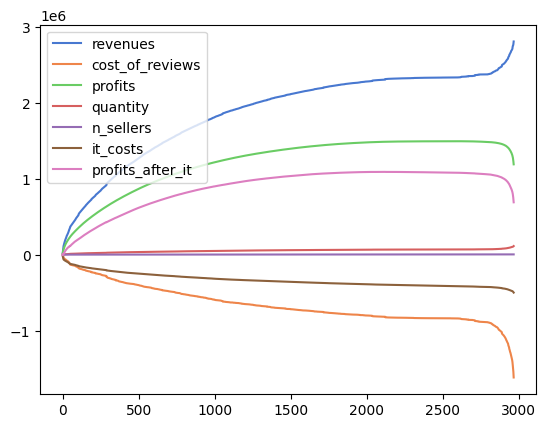

In [ ]:
metrics_cumulative_with_it['profits_after_it'] = metrics_cumulative_with_it['profits'] + metrics_cumulative_with_it['it_costs']
metrics_cumulative_with_it.plot();

In [ ]:
# Get the postion of max profit afte IT cost 
optimum_with_it = metrics_cumulative_with_it.profits_after_it.argmax()
optimum_with_it

2116

,impact
cost_of_reviews,799940.000000
it_costs,84976.134133
n_sellers,-850.000000
profits,297156.809000
profits_after_it,389239.646133
quantity,-46481.000000
revenues,-502783.191000


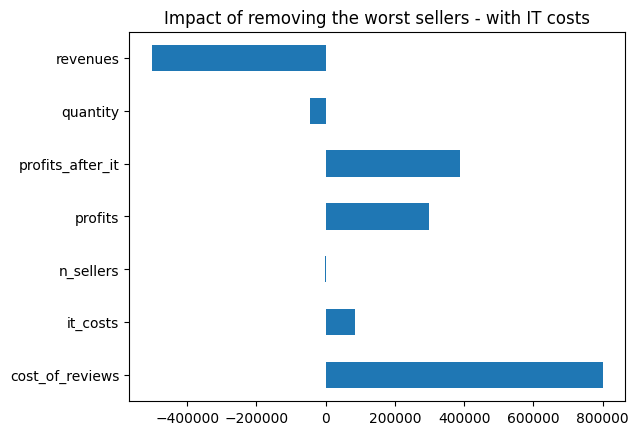

In [22]:
# Calculating the impact of removing the worst sellers
impact_with_it_costs = metrics_cumulative_with_it.iloc[optimum_with_it] - metrics_ordered.sum()
impact_with_it_costs['it_costs'] = metrics_cumulative_with_it.it_costs.iloc[optimum_without_it] \
                                 - metrics_cumulative_with_it.it_costs.iloc[-1]
impact_with_it_costs['profits_after_it'] = metrics_cumulative_with_it.profits_after_it.iloc[optimum_without_it] \
                                         - metrics_cumulative_with_it.profits_after_it.iloc[-1]
display(pd.DataFrame(impact_with_it_costs, columns=["impact"]))
impact_with_it_costs.plot(kind='barh', title="Impact of removing the worst sellers - with IT costs");

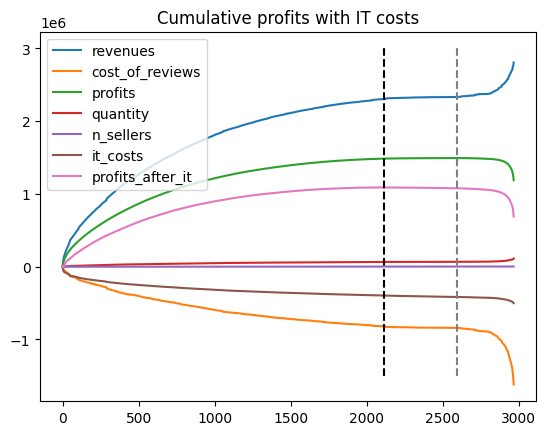

In [23]:
#  make plots to see how much impact the IT costs had on our analysis.
metrics_cumulative_with_it.plot(title="Cumulative profits with IT costs")
plt.vlines(optimum_with_it, ymin=-1.5e6, ymax=3e6, color='black', linestyle='--')
plt.vlines(optimum_without_it, ymin=-1.5e6, ymax=3e6, color='grey', linestyle='--');

## 3. Investigate other Approaches 

In [24]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
from IPython.display import Markdown as md

In [25]:
from olistClass.seller import Seller
seller = Seller()

In [ ]:
sellers = seller.get_training_data()

/Users/gechen/Projects/OlistDataAnalysis/olistClass/seller.py:102: FutureWarning:

The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.

/Users/gechen/Projects/OlistDataAnalysis/olistClass/seller.py:102: FutureWarning:

The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.



In [ ]:
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000,218.70,341.870,201.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,4.55,240,40,41,1.025,11703.07,2290.307,2050.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.000000,1.000000,5.00,0,1,1,1.000,158.00,15.800,15.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,0.000000,1.000000,5.00,0,1,1,1.000,79.99,7.999,7.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1.000000,0.000000,1.00,100,1,1,1.000,167.99,16.799,-83.201


# Olist Financials

## _Revenues_

In [28]:
# Revenues
revenues_sales = sellers.sales.sum() * 0.1
revenues_subscription = sellers.months_on_olist.sum() * 80
revenues_total = sellers.revenues.sum()

print(
    f'''
Revenues: {revenues_total:.2f} BRL
- Sales: {revenues_sales:.2f} BRL
- Subscriptions: {revenues_subscription:.2f} BRL
''')


Revenues: 2807418.44 BRL
- Sales: 1355578.44 BRL
- Subscriptions: 1451840.00 BRL



## _Costs_

In [29]:
costs_reviews = sellers.cost_of_reviews.sum()
costs_it = 500_000
costs_total = costs_reviews + costs_it

print(
    f'''
Costs: {costs_total:.2f} BRL
- Reviews: {costs_reviews:.2f} BRL
- IT: {costs_it:.2f} BRL
''')


Costs: 2118210.00 BRL
- Reviews: 1618210.00 BRL
- IT: 500000.00 BRL



## _Profits_

In [32]:
# Gross Profit, before IT costs
profits_gross = sellers.profits.sum()
profits_gross

1189208.4440000001

In [33]:
# Gross Profit, after IT costs
profits_net = profits_gross - costs_it
profits_net

689208.4440000001

In [ ]:
# Create a Waterfall chart to visualize how individual revenue and cost components
# cumulatively contribute to Olist’s overall profit and loss (P&L).
# - "measure" defines whether each bar is a relative change or a total subtotal.
# - "x" labels each financial component in order.
# - "y" provides the numeric values for revenues and costs (costs as negatives).
# - The chart shows step-by-step how subscriptions, sales fees, and costs accumulate
#   to form Gross Profit and finally Net Profit.

init_notebook_mode(connected=True)
fig = go.Figure(go.Waterfall(
    orientation = "v",
    measure = ["relative", "relative", "total", "relative", "total", "relative", "total"],
    x = ["Monthly subcriptions", "Sales fees", "Total Revenues", "Reviews costs", "Gross Profit", "It costs", "Net Profit"],
    textposition = "outside",
#    text = ["", "+80", "", "-40", "-20", "Total"],
    y = [revenues_subscription, revenues_sales, 0, -costs_reviews, 0,-costs_it, 0],
    connector = {"line":{"color":"rgb(63, 63, 63)"}},
))

fig.update_layout(
        title = {'text': "Olist Profit & Loss (BRL)",
                 'yanchor': 'top',
                 'xanchor': 'left',
                 'xref': 'paper',
                 'font': {'size': 36}},
        showlegend = False
)

fig.show()

# handle under-performing sellers to increase profit?

## 🕵️ What is an under-performing seller?

In [34]:
# Total number of sellers
n_sellers = sellers.shape[0]
# Number of sellers with negative profits
n_negative = sellers.query('profits <= 0').shape[0]
# % of sellers with negative profits
pct_negative = n_negative / n_sellers
# Mean and median of sellers'profits
mean, med = sellers.profits.mean(), sellers.profits.median()
# .25 quantile
q25 = sellers.profits.quantile(q=.25)
# Min, Max of sellers'profits
min_, max_ = sellers.profits.min(), sellers.profits.max()

In [36]:
n_sellers, n_negative, pct_negative, mean, med, q25, min_, max_

(2967,
 371,
 0.12504213009774182,
 400.8117438490058,
 257.84000000000003,
 21.8795,
 -21439.517,
 18067.605)

**In conclusin**:

There are **2967** sellers on Olist  

Insights on the **profits** they generate **for Olist**

**371 (12.6%)** of them generate a **negative profit**  

Profits across sellers from **-21k** to **18k** BRL  

The average profit per seller is **393** BRL  

**50%** of sellers generate at least a profit of **254** BRL  

**25%** of sellers generate a profit inferior to **30** BRL

In [37]:
STYLES = {'title': {'weight':'heavy', 'size':16,},
          'labels': {'weight': 'heavy', 'size': 14}}

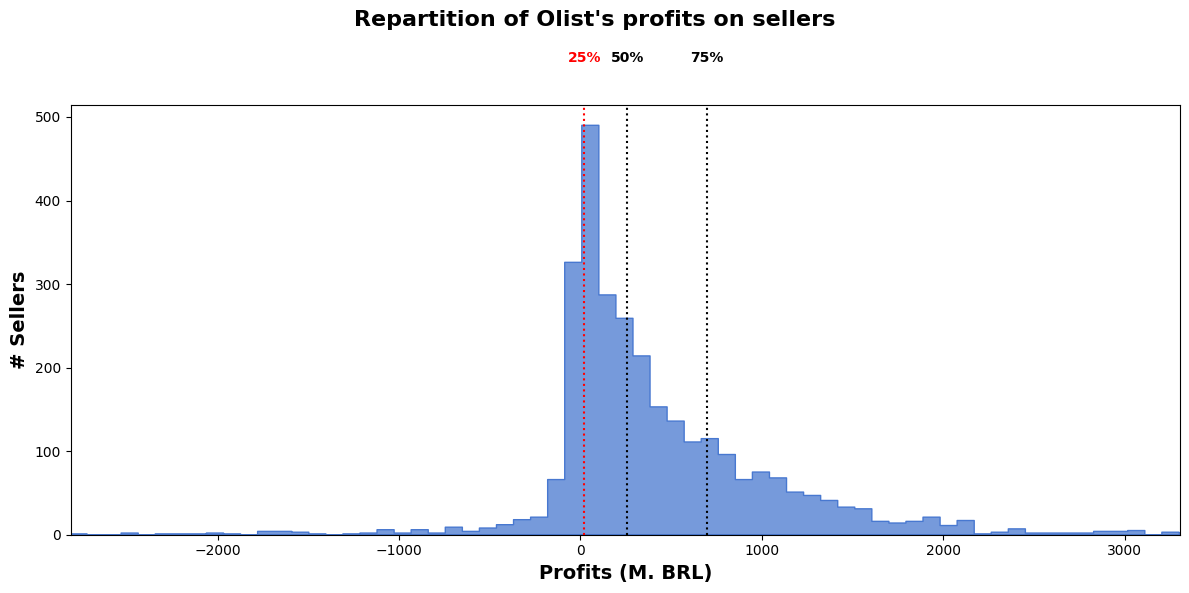

In [40]:
sns.set_palette('muted')

fig, ax = plt.subplots(figsize=(12, 6))

plt.suptitle(t="Repartition of Olist's profits on sellers",
             **STYLES['title'])

sns.histplot(sellers.profits,
             stat='count',
             element='step',
             ax=ax)

quantiles = sellers.profits.quantile(q=[.01, .25, .5, .75, .99])

ax.set_xlim(quantiles.iloc[0], quantiles.iloc[-1])
ax.set_xlabel(xlabel='Profits (M. BRL)',
              fontdict=STYLES['labels'])
ax.set_ylabel(ylabel='# Sellers',
              fontdict=STYLES['labels'])

for p, q in quantiles.iloc[1:-1].items():
    c_ = 'black'
    if p == .25:
        c_ = 'red'
    ax.axvline(x=q,
               color=c_,
               ls=':')
    ax.text(x=q,
            y=ax.get_yticks()[-1] - 30,
            s=f'{p:.0%}',
            color=c_,
            ha='center',
            va='center',
            weight='bold')

fig.tight_layout();

🎯 For reference, we will consider the **742** sellers that yielded a profit inferior to **30** BRL as **under-performers**

# What-if Analysis

### What could Olist have done to increase profits ...

### Let's see the financial impact of **removing sellers**, starting from the **less profitable one**

###  **rank** the sellers by **increasing profits**, and estimate the **costs** and **revenues** after removing them from Olist over the past 16 months

## Data preparation

In [52]:
sorted_sellers = sellers.sort_values(by='profits') \
                    [['months_on_olist',
                      'sales',
                      'profits',
                      'revenues',
                      'quantity',
                      'cost_of_reviews']] \
                    .reset_index()

sorted_sellers.head()

,index,months_on_olist,sales,profits,revenues,quantity,cost_of_reviews
0,769,19.0,123304.83,-21439.517,13850.483,2033,35290
1,2358,20.0,200472.92,-17752.708,21647.292,1987,39400
2,1357,19.0,104288.42,-17581.158,11948.842,1775,29530
3,945,12.0,37177.52,-15542.248,4677.752,1203,20220
4,315,10.0,17535.69,-12886.431,2553.569,1018,15440


In [ ]:
# Remaining gross profit after removing sellers one by one
gross_profits_per_seller_removed = profits_gross - np.cumsum(sorted_sellers.profits[:-1])
# Remaining review costs after removing sellers one by one
review_costs_per_seller_removed = costs_reviews - np.cumsum(sorted_sellers.cost_of_reviews[:-1])
# Remaining total revenue after removing sellers one by one
revenues_per_seller_removed = revenues_total - np.cumsum(sorted_sellers.revenues[:-1])

## Revenues

In [53]:
fees_per_seller_removed = revenues_sales - np.cumsum(sorted_sellers.sales[:-1] * .1)
suscriptions_per_seller_removed = revenues_subscription - np.cumsum(sorted_sellers.months_on_olist[:-1] * 80)

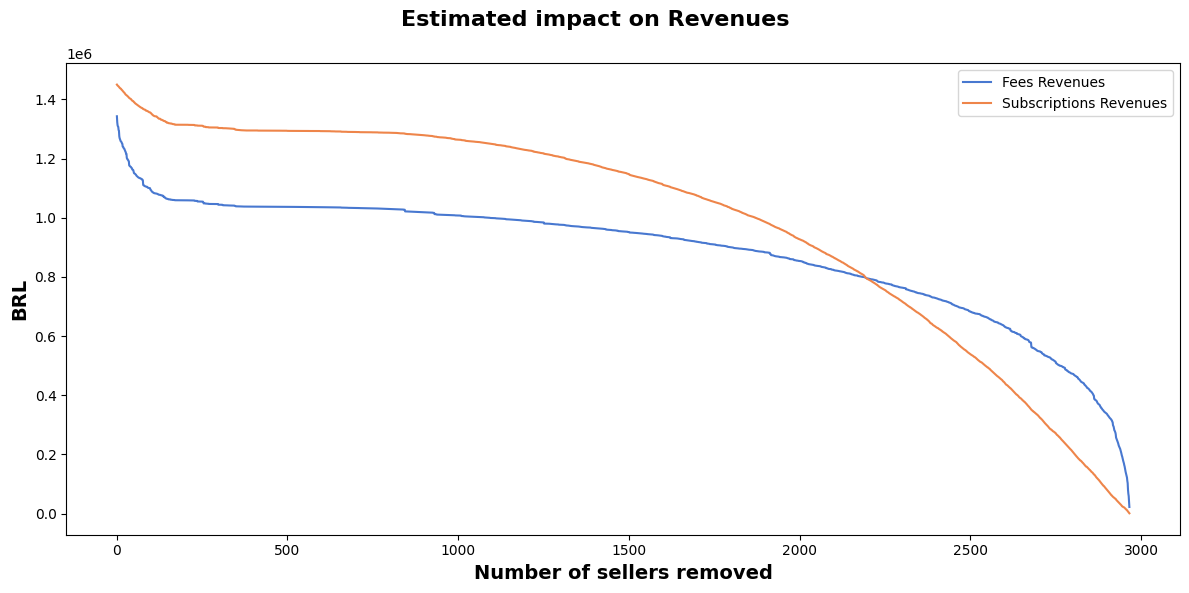

In [54]:
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(1, n_sellers, 1)

plt.suptitle(t="Estimated impact on Revenues",
             **STYLES['title'])

fees_line = sns.lineplot(x=x,
                         y=fees_per_seller_removed,
                         label='Fees Revenues',
                         ax=ax)

subscriptions_line = sns.lineplot(x=x,
                                  y=suscriptions_per_seller_removed,
                                  label='Subscriptions Revenues',
                                  ax=ax)

ax.set_xlabel('Number of sellers removed',
                  fontdict=STYLES['labels'])
ax.set_ylabel('BRL',
                  fontdict=STYLES['labels'])

ax.tick_params(axis='y')

ax.legend()

fig.tight_layout()

### IT Costs scaling parameters $\alpha$ and $\beta$

know that the total IT Costs scale with both the number of sellers (`n_sellers`) and the amount of items they sold (`n_items`)  

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_items}$  

- $\alpha = 3157.27$
- $\beta = 978.23$

In [55]:
alpha, beta = 3157.27, 978.23
n_sellers = sellers.shape[0]
n_items = sellers.quantity.sum()

In [56]:
def compute_costs_of_it(n_sellers, n_items):
    return alpha * np.sqrt(n_sellers) + beta * np.sqrt(n_items)

In [57]:
new_n_sellers = n_sellers - np.arange(1, n_sellers, 1)
new_n_items = n_items - np.cumsum(sorted_sellers.quantity[:-1])

it_costs_per_seller_removed = compute_costs_of_it(new_n_sellers, new_n_items)
review_costs_per_seller_removed = sellers.cost_of_reviews.sum() - np.cumsum(sorted_sellers.cost_of_reviews[:-1])

costs_per_seller_removed = it_costs_per_seller_removed + review_costs_per_seller_removed

## Costs

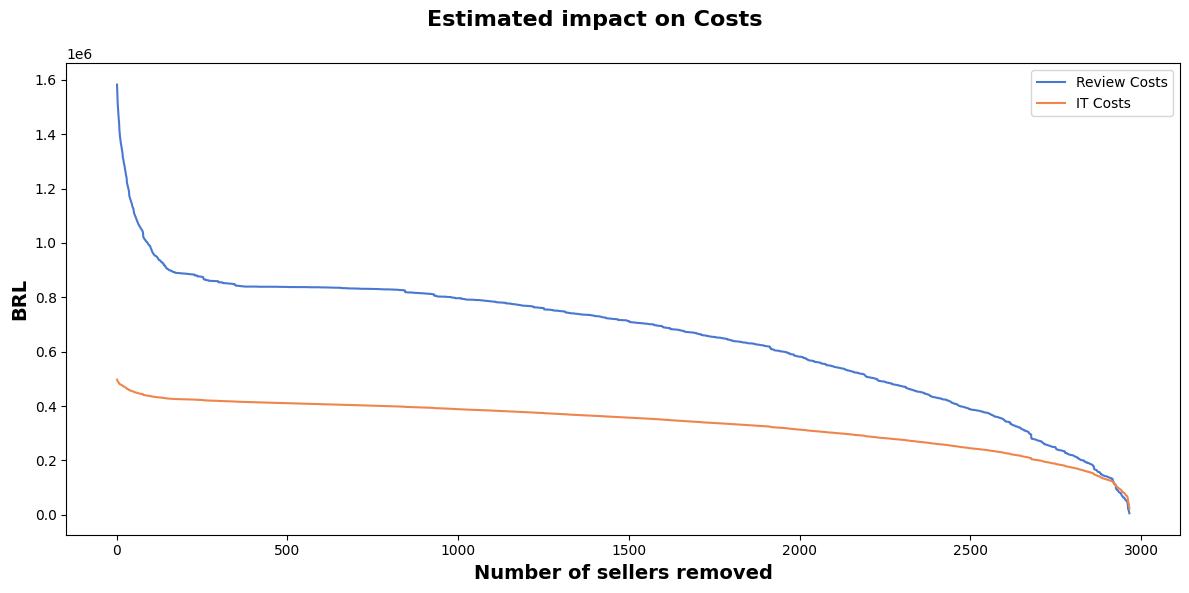

In [58]:
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(1, n_sellers, 1)

plt.suptitle(t="Estimated impact on Costs",
             **STYLES['title'])

review_costs_line = sns.lineplot(x=x,
                                 y=review_costs_per_seller_removed,
                                 label='Review Costs',
                                 ax=ax)

it_costs_line = sns.lineplot(x=x,
                             y=it_costs_per_seller_removed,
                             label='IT Costs',
                             ax=ax)

ax.set_xlabel('Number of sellers removed',
                  fontdict=STYLES['labels'])
ax.set_ylabel('BRL',
                  fontdict=STYLES['labels'])

ax.tick_params(axis='y')

ax.legend()

fig.tight_layout()

**💡 Removing the less profitable sellers nets a great decrease of the estimated costs of bad reviews**  
**💡 IT Costs seem less relevant to this analysis**

In [59]:
# Compute final metrics (profits and margin, for each scenario!)
profits_per_seller_removed = gross_profits_per_seller_removed - it_costs_per_seller_removed
margin_per_seller_removed = profits_per_seller_removed / revenues_per_seller_removed

#  How many under-performers to remove?

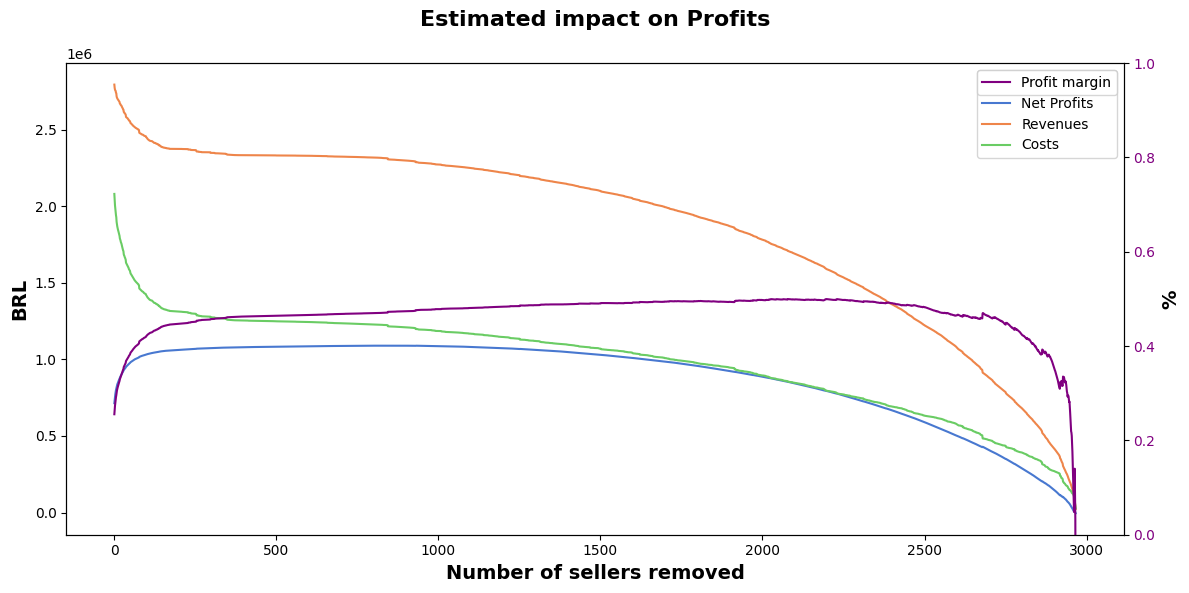

In [50]:
fig, ax = plt.subplots(figsize=(12, 6))

axs = [ax, ax.twinx()]

x = np.arange(1, n_sellers, 1)

plt.suptitle(t="Estimated impact on Profits",
             **STYLES['title'])

net_profit_line = sns.lineplot(x=x,
                               y=profits_per_seller_removed,
                               label='Net Profits',
                               ax=axs[0])

revenue_line = sns.lineplot(x=x,
                            y=revenues_per_seller_removed,
                            label='Revenues',
                            ax=axs[0])

costs_line = sns.lineplot(x=x,
                          y=costs_per_seller_removed,
                          label='Costs',
                          ax=axs[0])

axs[0].set_xlabel('Number of sellers removed',
                  fontdict=STYLES['labels'])
axs[0].set_ylabel('BRL',
                  fontdict=STYLES['labels'])

axs[0].tick_params(axis='y')

margin_line = sns.lineplot(x=x,
                           y=margin_per_seller_removed,
                           label='Profit margin',
                           color='purple',
                          ax=axs[1])

axs[1].set_ylabel('%',
                  fontdict=STYLES['labels'])
axs[1].tick_params(axis='y',
                   labelcolor='purple')
axs[1].set(ylim=[0, 1])

lines = [axs[1].lines[0], *axs[0].lines]
labels = [line.get_label() for line in lines]
axs[0].legend(lines, labels)

fig.tight_layout()

In [75]:
# Find optimal number of sellers to remove
profits_per_seller_removed.argmax(), profits_per_seller_removed.argmax() / n_sellers, \
margin_per_seller_removed.argmax(), margin_per_seller_removed.argmax() / n_sellers

(849, 0.2861476238624874, 2196, 0.7401415571284126)

###  Decision thresholds
#### 👉 Optimizing for **profits** requires removing **854 (29%)** sellers
#### 👉 Optimizing for the **profit margin** requires removing **2244 (76%)** sellers  